# FACEMASK DETECTION

#### STEP 1: Gathering the data
The image data is located in the dataset folder. In the folder are two folders; mask (faces with mask on) and no_mask (faces with no mask on). The code below downloads this folder from google drive.

In [ ]:
import gdown

!gdown https://drive.google.com/uc?id=1ClrgAafxBW_WzLtAnY7-RztsNbVcu27q

Downloading...
From: https://drive.google.com/uc?id=1ClrgAafxBW_WzLtAnY7-RztsNbVcu27q
To: /content/mask_dataset.zip
78.2MB [00:01, 49.8MB/s]


Let's extract the data

In [ ]:
import os
import shutil
import zipfile

# local_zip = 'mask_dataset.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('')
# zip_ref.close()

base_dir = 'dataset'
mask_dir = os.path.join(base_dir, 'mask')
no_mask_dir = os.path.join(base_dir, 'no_mask')

mask_dir_fnames = os.listdir(mask_dir)
no_mask_dir_fnames = os.listdir(no_mask_dir)

# shutil.rmtree('validation')
# Split data 70%-30% into training set and test set
# create the directories where the images will be stored. you can also manually create the directories and commnet this part out
# try:
#     os.makedirs('train/no_mask', exist_ok=True)
#     os.makedirs('validation/no_mask', exist_ok=True)
#     os.mkdir(os.path.join('train', 'mask'))
#     os.mkdir(os.path.join('validation', 'mask'))
# except:
#     # assuming the a directory already exists
#     pass

# # copying the files into there directories
# for count, name in enumerate(mask_dir_fnames):
#     if count >= (len(mask_dir_fnames) * 0.7):
#         shutil.copy(f'{mask_dir}/{name}', 'validation/mask')
#         continue
#     shutil.copy(f'{mask_dir}/{name}', 'train/mask')

# for count, name in enumerate(no_mask_dir_fnames):
#     if count >= (len(no_mask_dir_fnames) * 0.7):
#         shutil.copy(f'{no_mask_dir}/{name}', 'validation/no_mask')
#         continue
#     shutil.copy(f'{no_mask_dir}/{name}', 'train/no_mask')

train_dir = 'train'
validation_dir = 'validation'

# Directory with our training mask pictures
train_mask_dir = os.path.join(train_dir, 'mask')

# Directory with our training no_mask pictures
train_no_mask_dir = os.path.join(train_dir, 'no_mask')

# Directory with our validation mask pictures
validation_mask_dir = os.path.join(validation_dir, 'mask')

# Directory with our validation no_mask pictures
validation_no_mask_dir = os.path.join(validation_dir, 'no_mask')

print("Mask Train Size: ", len(os.listdir(train_mask_dir)))
print("No Mask Train Size: ", len(os.listdir(train_no_mask_dir)))
print("Mask validation Size: ", len(os.listdir(validation_mask_dir)))
print("No Mask validation Size: ", len(os.listdir(validation_no_mask_dir)))

Mask Train Size:  610
No Mask Train Size:  630
Mask validation Size:  261
No Mask validation Size:  270


Let's explore what happens with data augmentation

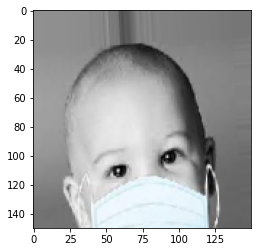

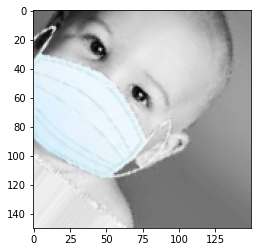

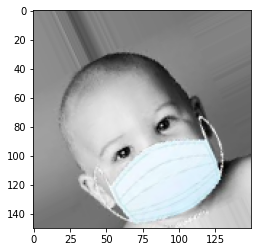

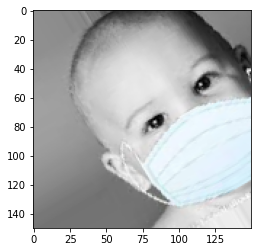

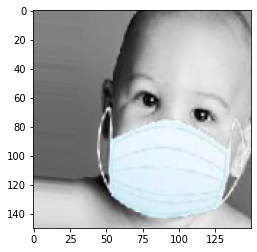

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_mask_fnames = os.listdir(train_mask_dir)
train_no_mask_fnames = os.listdir(train_no_mask_dir)

img_path = os.path.join(train_mask_dir, train_mask_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

#### Step 2: Add Data Augmentation to the Preprocessing Step

In [ ]:
img_size = (150, 150)
batch_size = 20

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=img_size,  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=img_size,  # All images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Found 1240 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
class names:  ['mask', 'no_mask']


**Adding Dropout**

Another popular strategy for fighting overfitting is to use dropout.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)       

**Retrain the model**

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples // batch_size,
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
62/62 - 40s - loss: 0.8061 - acc: 0.6476 - val_loss: 0.2670 - val_acc: 0.9404
Epoch 2/30
62/62 - 40s - loss: 0.3954 - acc: 0.8427 - val_loss: 0.1586 - val_acc: 0.9423
Epoch 3/30
62/62 - 40s - loss: 0.3277 - acc: 0.8718 - val_loss: 0.1614 - val_acc: 0.9635
Epoch 4/30
62/62 - 39s - loss: 0.2835 - acc: 0.9016 - val_loss: 0.1962 - val_acc: 0.9462
Epoch 5/30
62/62 - 40s - loss: 0.3005 - acc: 0.8879 - val_loss: 0.0940 - val_acc: 0.9712
Epoch 6/30
62/62 - 39s - loss: 0.2395 - acc: 0.8976 - val_loss: 0.1127 - val_acc: 0.9615
Epoch 7/30
62/62 - 39s - loss: 0.2574 - acc: 0.9073 - val_loss: 0.0843 - val_acc: 0.9750
Epoch 8/30
62/62 - 39s - loss: 0.2155 - acc: 0.9218 - val_loss: 0.1116 - val_acc: 0.9712
Epoch 9/30
62/62 - 44s - loss: 0.2171 - acc: 0.9242 - val_loss: 0.0937 - val_acc: 0.9635
Epoch 10/30
62/62 - 39s - loss: 0.2035 - acc: 0.9242 - val_loss: 0.1545 - val_acc: 0.9442
Epoch 11/30
62/62 - 39s - loss: 0

# Model Evaluation

We start by checking the model training and validation acuracy

Text(0.5, 1.0, 'Training and validation loss')

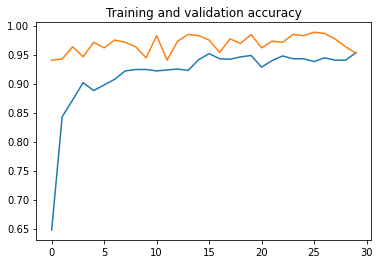

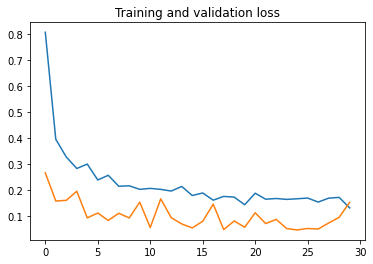

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

**Confusion Matrix evaluation and Accuracy**

Generating predictions from validation data...
[1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
Confusion Matrix :[[11  0]
 [ 2  7]]
Accuracy: 0.9


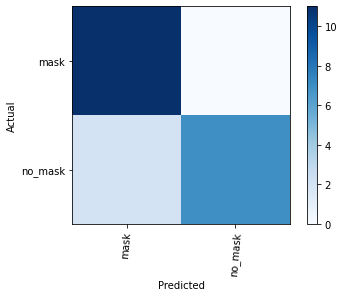

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]


# The model returns a probability value for each class
# The one with the highest probability is the predicted class
probabilities = model.predict(x_test)


# O is mask
# 1 is no mask
predictions = [0 if x < 0.5 else 1 for x in probabilities]
print(predictions)

# The actual labels are hot encoded (e.g. [0 1], so get the one with the value 1
true_labels = y_test
print(true_labels)

# In this case the costly error I beleive is saying that someone who has no mask has a mask

# Plot the confusion matrix and other accuracy metrics
cm = metrics.confusion_matrix(true_labels, predictions)
accuracy = metrics.accuracy_score(true_labels, predictions)
print(f"Confusion Matrix :{cm}")
print(f"Accuracy: {accuracy}")
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Classification Report**

In [ ]:
report = metrics.classification_report(true_labels, predictions)
print(f"Report: {report}")

Report:               precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        11
         1.0       1.00      0.78      0.88         9

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20



**ROC Curve**

AUC :1.0


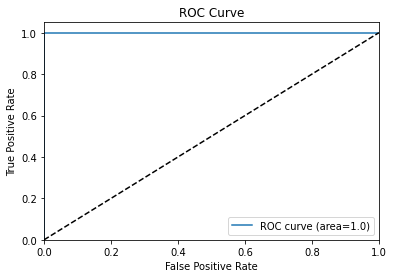

In [ ]:
# determine the false positive and true positive rates
fpr, tpr, _ = metrics.roc_curve(true_labels, probabilities)

# calculate the AUC
roc_auc = metrics.auc(fpr, tpr)
print(f"AUC :{roc_auc}")

# plot of ROC Curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area={roc_auc})')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Finding the optimal cutoff point**

In [ ]:
# Code for optimal Cutoff point here

#### Saving the model in HDF5 Format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('models/model-v2.h5') 

#### Recreate the model from that file

Profile Face Detected
PREDICTION: no_mask


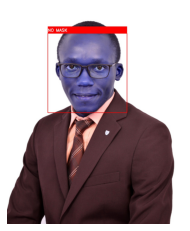

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
from tensorflow.keras import models
from tensorflow.image import resize, decode_jpeg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
%matplotlib inline

new_model = models.load_model('models/model-v2.h5')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
profile_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

image_gray = cv2.imread('8.jpeg', cv2.IMREAD_GRAYSCALE)
image=mpimg.imread('8.jpeg')
plt.axis('off')
plt.imshow(image)

img_height = 150
img_width = 150

# Detects faces of different sizes in the input image 
frontal_faces = face_cascade.detectMultiScale(image_gray, 1.3, 5)
profile_faces = profile_face_cascade.detectMultiScale(image_gray, 1.3, 5)
labels_dict = {0:'MASK', 1:'NO MASK'}
color_dict = {0:(0,255, 0), 1:(0,0,255)}

if len(frontal_faces) == 0 and len(profile_faces) > 0:
    faces = profile_faces
    print('Profile Face Detected')
elif len(profile_faces) == 0 and len(frontal_faces) > 0:
    faces = frontal_faces
    print('Frontal Face Detected')
else:
    faces = []
    print('No Face Detected')

if len(faces) == 0:
    x = 20
    y = 100
    h = 300
    w = 300
    resized_image = cv2.resize(image, (img_height, img_width))
    imgfeatures = resized_image.reshape(1, 150, 150, 3)
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    class_probabilities = new_model.predict(imgfeatures)
    class_idx = [0 if x < 0.5 else 1 for x in class_probabilities]
    classnames = ['mask', 'no_mask']
    print(f'PREDICTION: {classnames[int(class_idx[0])]}')
    label = int(class_idx[0])

    cv2.rectangle(image,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(image,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(image, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imwrite('output/8.jpeg', image)
    image=mpimg.imread('output/8.jpeg')
    plt.axis('off')
    plt.imshow(image)
    
for (x,y,w,h) in faces:
    image_color = image[y:y+h, x:x+w]
    plt.imshow(image_color)
    resized_image = cv2.resize(image_color, (img_height, img_width))
    imgfeatures = resized_image.reshape(1, 150, 150, 3)
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    class_probabilities = new_model.predict(imgfeatures)
    class_idx = [0 if x < 0.5 else 1 for x in class_probabilities]
    classnames = ['mask', 'no_mask']
    print(f'PREDICTION: {classnames[int(class_idx[0])]}')
    label = int(class_idx[0])

    cv2.rectangle(image,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(image,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(image, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imwrite('output/8.jpeg', image)
    image=mpimg.imread('output/8.jpeg')
    plt.axis('off')
    plt.imshow(image)

plt.show()

# !wget --no-check-certificate https://media.allure.com/photos/5e34ab188a385400093f2a16/3:4/w_1500,h_2000,c_limit/mask.jpg
# !wget --no-check-certificate https://unric.org/en/wp-content/uploads/sites/15/2020/05/wendy-schellemans-transparent-mask.jpg
# !wget --no-check-certificate https://qodebrisbane.com/wp-content/uploads/2019/07/This-is-not-a-person-2-1.jpeg
# os.rename('wendy-schellemans-transparent-mask.jpg', 'transparent_mask.jpg')
# os.rename('This-is-not-a-person-2-1.jpeg', 'no_mask.jpg')

# The model expects a batch of images as input, so we'll create an array of 1 image


# We need to format the input to match the training data
# The generator loaded the values as floating point numbers
# and normalized the pixel values, so...

# Find the class predictions with the highest predicted probability

# prediction_dir = 'prediction'

# All images will be rescaled by 1./255
# pred_datagen = ImageDataGenerator(rescale=1./255)

# Flow prediction images in batches of 20 using pred_datagen generator
# prediction_generator = pred_datagen.flow_from_directory(
#         prediction_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

# print(new_model.predict(prediction_generator).shape)

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)